In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
import matplotlib
from typing import Tuple
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
data_path = Path("../data")

In [7]:
df_final = pd.read_parquet(data_path / "full_data.parquet")

reordenar las columnas para visualizar de forma mas intuitiva.  

In [8]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df_final = df_final[column_order]
df_final['churn'] = df_final['churn'].astype(int)

In [ ]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56335 entries, 0 to 56334
Data columns (total 67 columns):
 #   Column                                          Non-Null Count  Dtype    
---  ------                                          --------------  -----    
 0   advertiser_zrive_id                             56335 non-null  int64    
 1   period_int                                      56335 non-null  int64    
 2   monthly_published_ads                           56335 non-null  int64    
 3   monthly_published_ads_3_months_mean             56335 non-null  float64  
 4   monthly_published_ads_3_months_mean_delta       56335 non-null  float64  
 5   monthly_unique_published_ads                    56335 non-null  int64    
 6   monthly_contracted_ads                          56335 non-null  int64    
 7   monthly_contracted_ads_3_months_mean            56335 non-null  float64  
 8   monthly_contracted_ads_3_months_mean_delta      56335 non-null  float64  
 9   monthly_leads         

Existe un patron, cuando hay NaN en monthly_avg_ad_price, suele haber NaN en monthly_distint_ads.

Además siempre ocurre en los primeros meses de cada usuario ¿motivo?


In [10]:
nulls_df_final = df_final[['advertiser_zrive_id', 'period_int', 'monthly_published_ads',
         'monthly_contracted_ads','monthly_avg_ad_price', 'monthly_distinct_ads', 'churn']]

# Train models

Primero entrenar un modelo con un periodo, para justificar que modelos no lineales mejoran modelos lineales

Despues entrenar modelo no lineal por cada periodo y ver metricas

In [20]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period']
label_col = 'churn'
features_cols = [col for col in df_final.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [21]:
train_df = df_final[
    (df_final['month_period'] >= '202303') &
    (df_final['month_period'] < '202401')
]

val_df = df_final[df_final['month_period'] == '202401']

In [22]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [23]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [24]:
train_cols = numerical_cols + binary_cols
train_cols = [col for col in train_cols if not df_final[col].isna().any()]

In [ ]:
# model basic
lr = LogisticRegression(
    random_state=29,
)

lr.fit(X_train[train_cols], y_train)

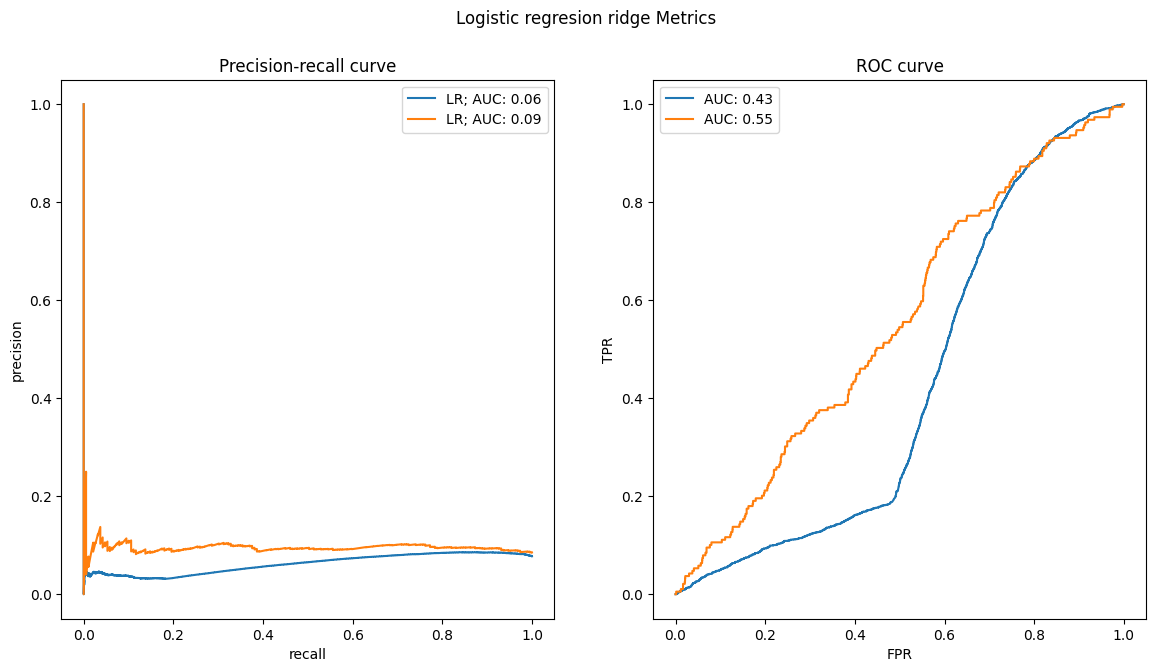

In [38]:
y_train_pred_LogReg_model = lr.predict(X_train[train_cols])
y_test_pred_LogReg_model = lr.predict(X_val[train_cols])

fig1, ax1 = plt.subplots(1, 2, figsize=(14, 7))
fig1.suptitle("Logistic regresion ridge Metrics")


val_proba = lr.predict_proba(X_train[train_cols])[:, 1]
plot_metrics(
    f"LR", y_pred=val_proba, y_test=train_df[label_col], figure=(fig1, ax1)
)

val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
    f"LR", y_pred=val_proba, y_test=val_df[label_col], figure=(fig1, ax1)
)

In [39]:
feature_importance = pd.DataFrame(
    {
        "Feature": [f"Feature_{column}" for column in X_train[train_cols].columns],
        "Weight": abs(lr.coef_[0]),  # Coeficientes del modelo
    }
).sort_values(by="Weight", ascending=False)
feature_importance

,Feature,Weight
46,Feature_visits_per_published_ad_3_months_mean,1.283118e-04
47,Feature_visits_per_published_ad_3_months_mean_...,9.758919e-05
27,Feature_monthly_avg_ad_price,6.782937e-05
22,Feature_monthly_total_invoice_3_months_mean,4.584265e-05
21,Feature_monthly_total_invoice,4.123907e-05
...,...,...
35,Feature_ratio_unique_published_3_months_mean_d...,4.254781e-10
52,Feature_leads_per_shows_3_months_mean,5.331615e-11
51,Feature_leads_per_shows,4.140714e-11
50,Feature_leads_per_visit_3_months_mean_delta,2.184397e-11


# Ridge Regression

c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\maick\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

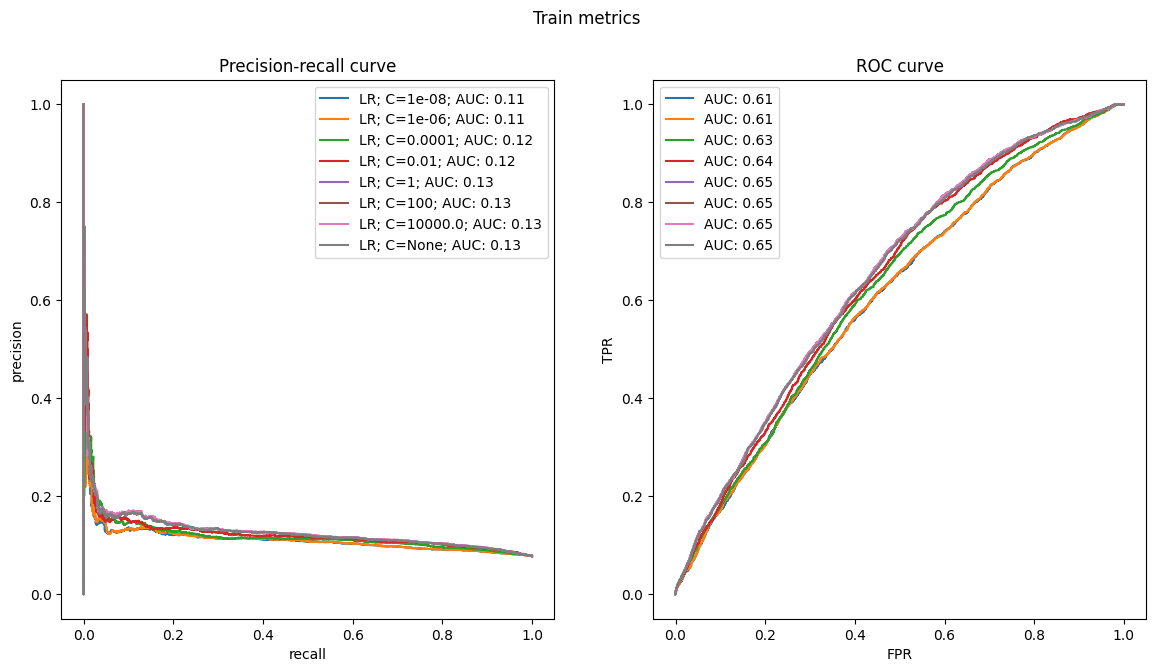

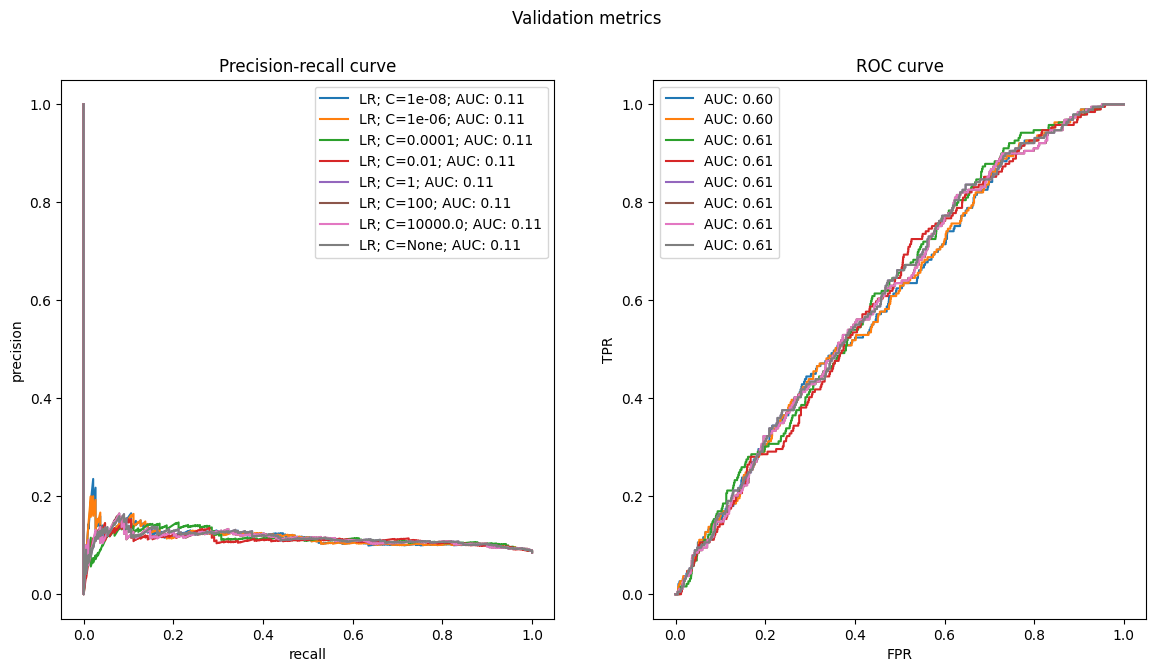

In [45]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



* Los dos modelos con mayor regularización (C= 1e-8 y 1e-6) muestran rendimientos similares en train y en validation. 

* No obstante, la regularización no tiene mucho impacto, ya que el modelo lineal no es capaz de capturar patrones posiblemente no lineales

# Lasso Regression

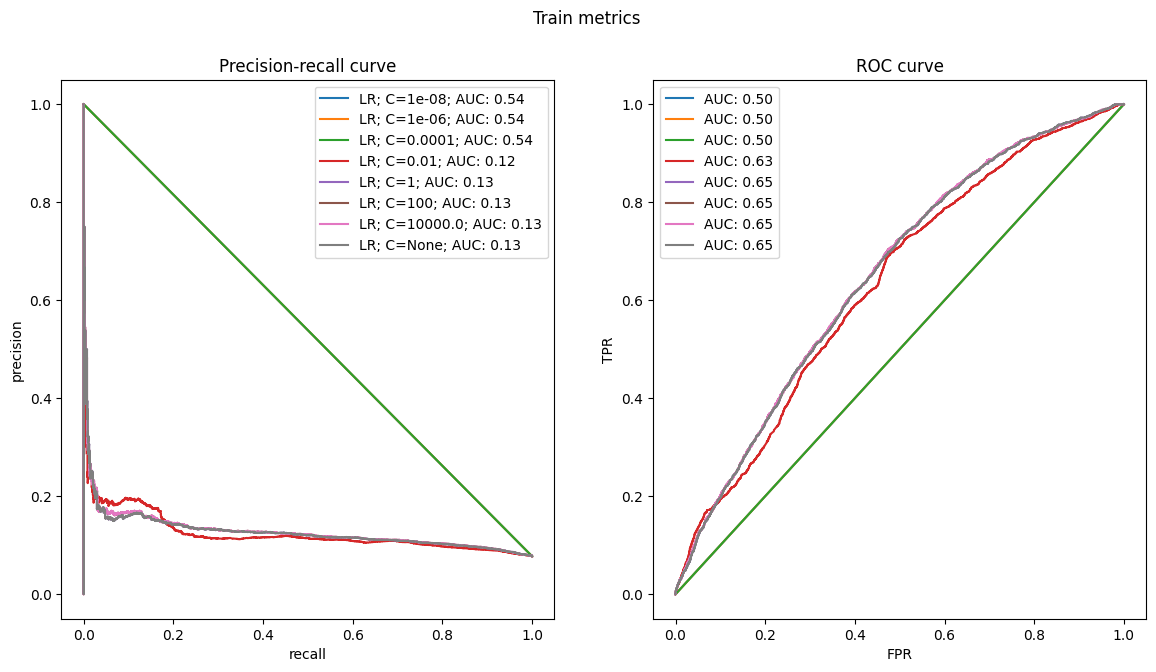

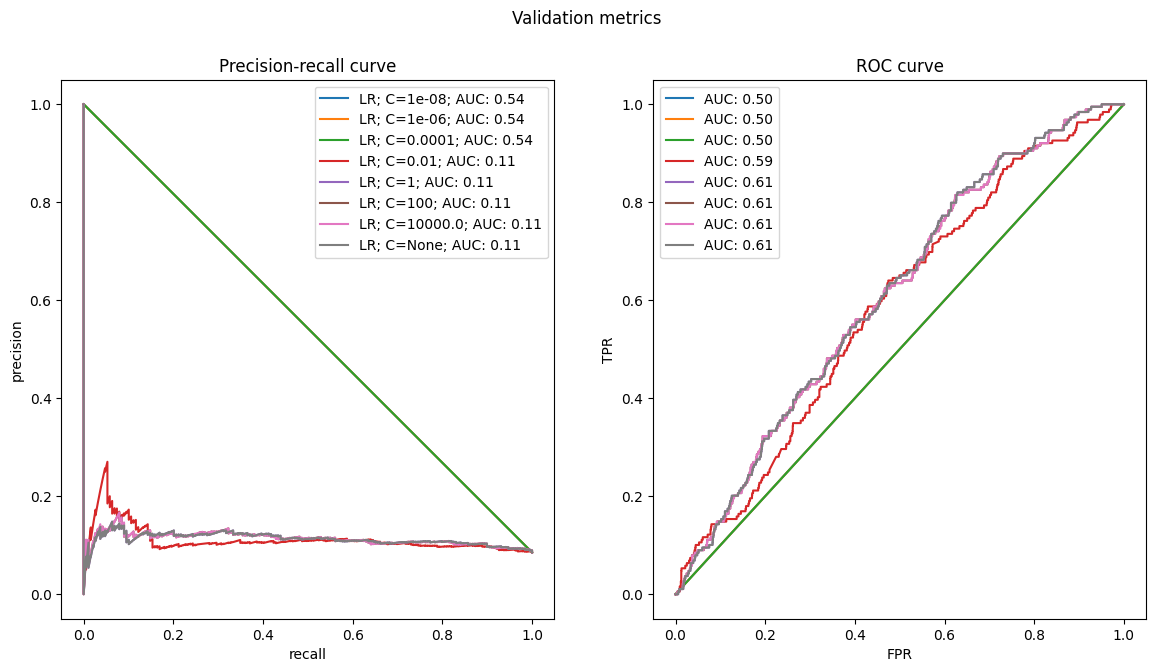

In [ ]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento

lr_push_train_aucs = []
lr_push_val_aucs = []
lr_push_train_ce = []
lr_push_val_ce = []


fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-8, 1e-6, 1e-4, 1e-2, 1, 100, 1e4, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l1", C=c if c else 1.0, solver='liblinear'),  # Cambiado a L1 y añadido solver
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)

    )

In [43]:
# model basic
lr = LogisticRegression(
    penalty="l1",
    class_weight="balanced",
    solver='liblinear'
)

lr.fit(X_train[train_cols], y_train)
y_train_pred_LogReg_ridge_model = lr.predict(X_val[train_cols])

print(
    "Report Train:\n", classification_report(y_val, y_train_pred_LogReg_ridge_model)
)

Report Train:
               precision    recall  f1-score   support

           0       0.94      0.58      0.72      2023
           1       0.11      0.58      0.19       189

    accuracy                           0.58      2212
   macro avg       0.53      0.58      0.45      2212
weighted avg       0.87      0.58      0.67      2212



* En este caso el rendimiento en train si que es algo mejor que en validation (en las curvas ROC sobretodo)

Nos podemos quedar con el modelo ridge con C=1e-6 como baseline

# Coefficients weights

In [ ]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-6)),  #elijo el que parecia que funcionaba mejor
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"] * len(train_cols),
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)


lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1e-2, solver="saga"),)
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)

lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)

/Users/alex/Library/Caches/pypoetry/virtualenvs/zrive-ds-BjTOAo2L-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [ ]:
lr_coeff_l2["features"] = pd.Categorical(lr_coeff_l2["features"])
lr_coeff_l2 = lr_coeff_l2.sort_values(by=["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending = False)["features"]

top_20_features_l2 = lr_coeff_l2.sort_values(by="importance", ascending=False).head(20)

'''sns.barplot(
    data=top_20_features_l2,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_20_features_l2["features"]
)'''

<Axes: xlabel='importance', ylabel='features'>

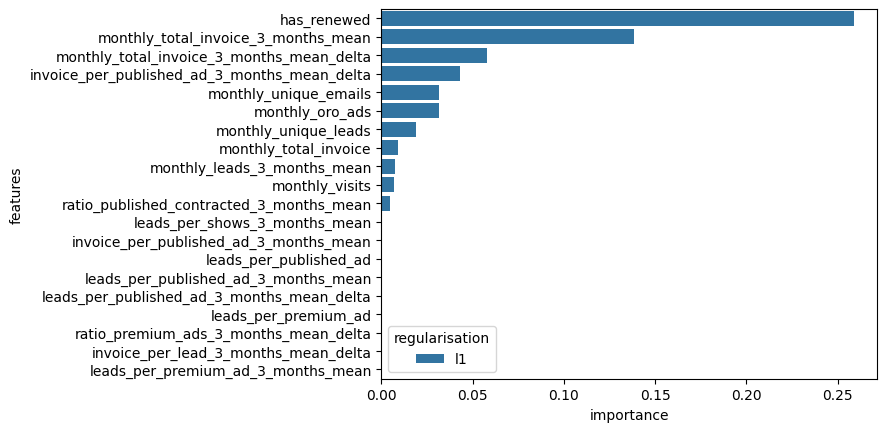

In [ ]:
lr_coeff_l1["features"] = pd.Categorical(lr_coeff_l1["features"])
lr_coeff_l1 = lr_coeff_l1.sort_values(by=["importance"])
order_columns = lr_coeff_l1.sort_values(by="importance", ascending = False)["features"]


top_20_features_l1 = lr_coeff_l1.sort_values(by="importance", ascending=False).head(20)


'''sns.barplot(
    data=top_20_features_l1,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_20_features_l1["features"]
)'''

Para Lasso, solo importan las variables

* has_renewed

* monthly_total_invoice_3_months_mean

* monthly_total_invoice_3_months_mean_delta

* invoice_per_published_ad_3_months_mean_delta

* monthly_unique_emails

* monthly_oro_ads

* monthly_unique_leads

* monthly_total_invoice

* monthly_leads_3_months_mean

* monthly_visits

* ratio_published_contracted_3_months_mean

Vamos a probar un modelo con L1 y otro con L2 con estas variables unicamente y si el renidmiento es parecido, nos quedamos como baseline este modelo

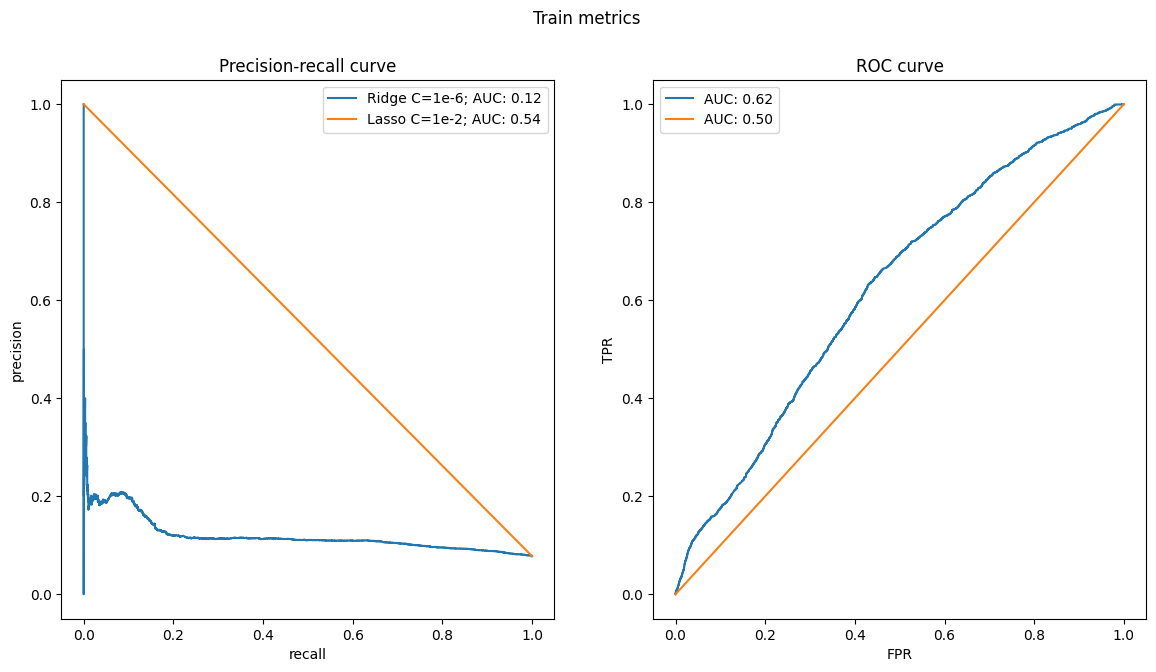

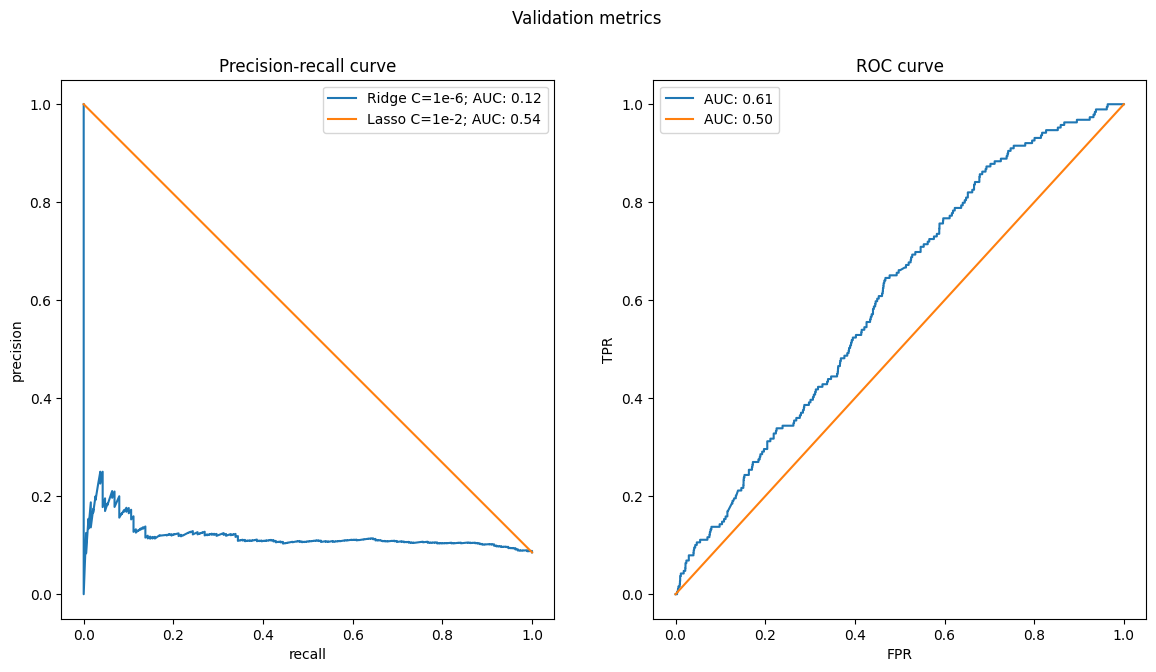

In [ ]:
reduced_cols = ["has_renewed", "monthly_total_invoice_3_months_mean", "monthly_total_invoice_3_months_mean_delta", "invoice_per_published_ad_3_months_mean_delta",
 "monthly_unique_emails", "monthly_oro_ads", "monthly_unique_leads", "monthly_total_invoice", "monthly_leads_3_months_mean", "monthly_visits",
"ratio_published_contracted_3_months_mean" ]

fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize= (14,7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-6)),
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=1e-4, solver="saga")
    )
]

names = ["Ridge C=1e-6", "Lasso C=1e-2"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )



Nos quedamos como baseline con el modelo Ridge

# Modelos no lineales

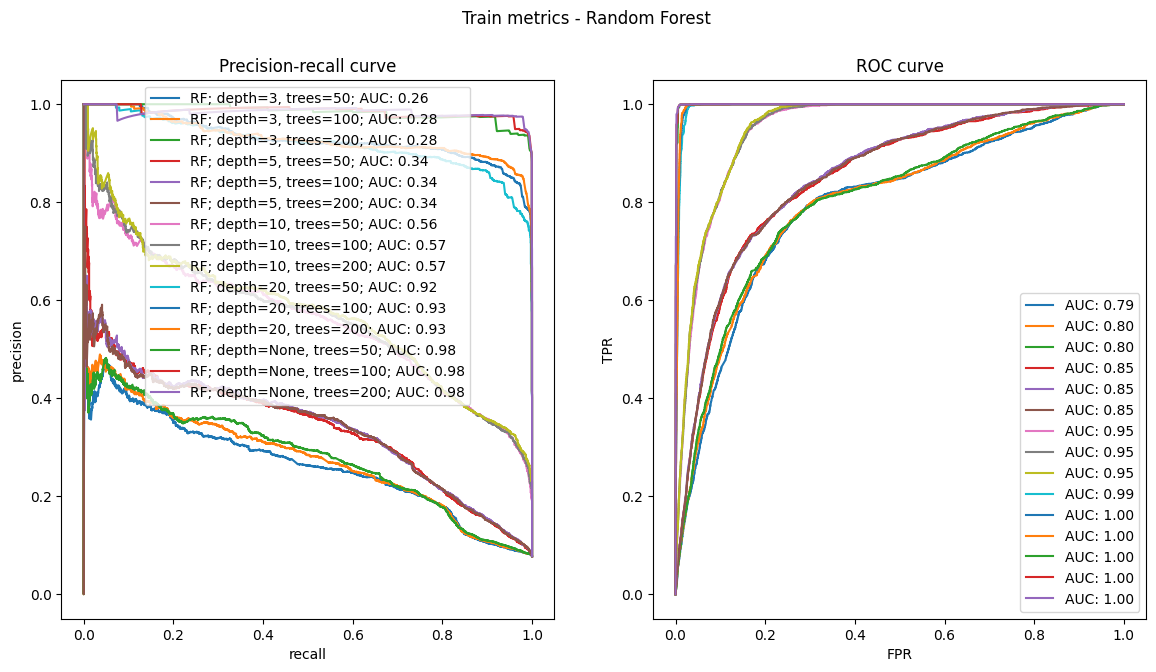

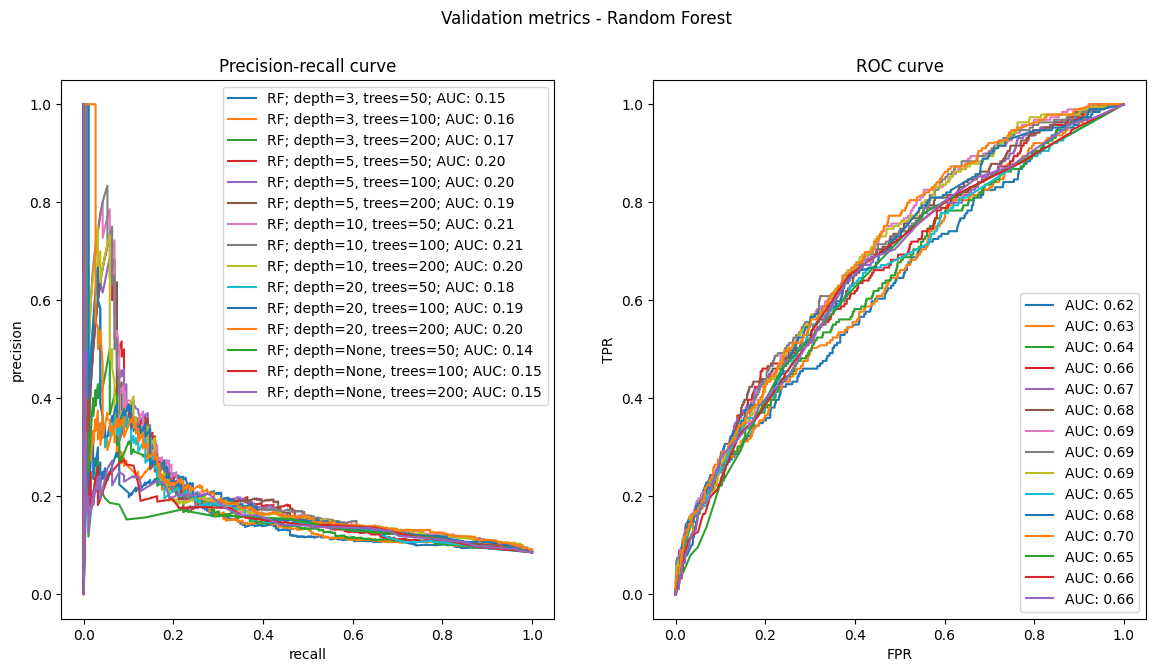

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Configurar parámetros a probar
max_depths = [3, 5, 10, 20, None]
n_estimators_list = [50, 100, 200]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=42,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[train_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )



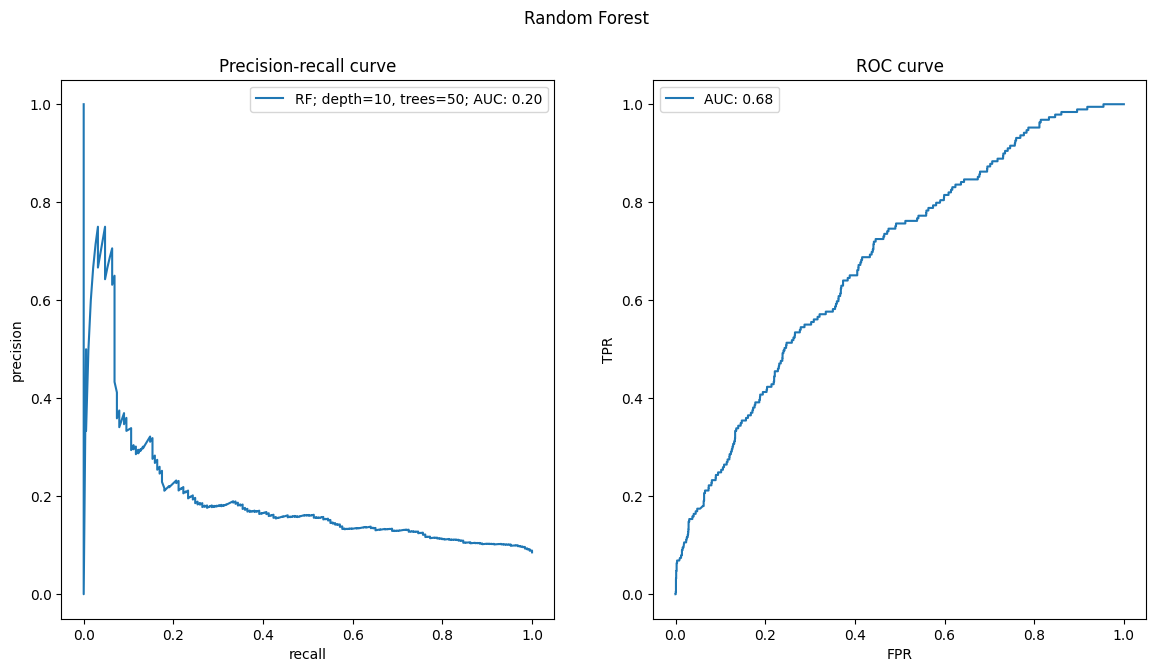

In [47]:
from sklearn.ensemble import RandomForestClassifier


# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Random Forest")

rf = make_pipeline(
    RandomForestClassifier(
        max_depth=10,
        n_estimators=50,
        random_state=42,
        class_weight='balanced'  # Para manejar desbalance de clases
    )
)
        
rf.fit(X_train[train_cols], y_train)


val_proba = rf.predict_proba(X_val[train_cols])[:,1]
plot_metrics(
            f"RF; depth=10, trees=50", 
            val_proba,
            y_val,
            figure=(fig1, ax1)
        )

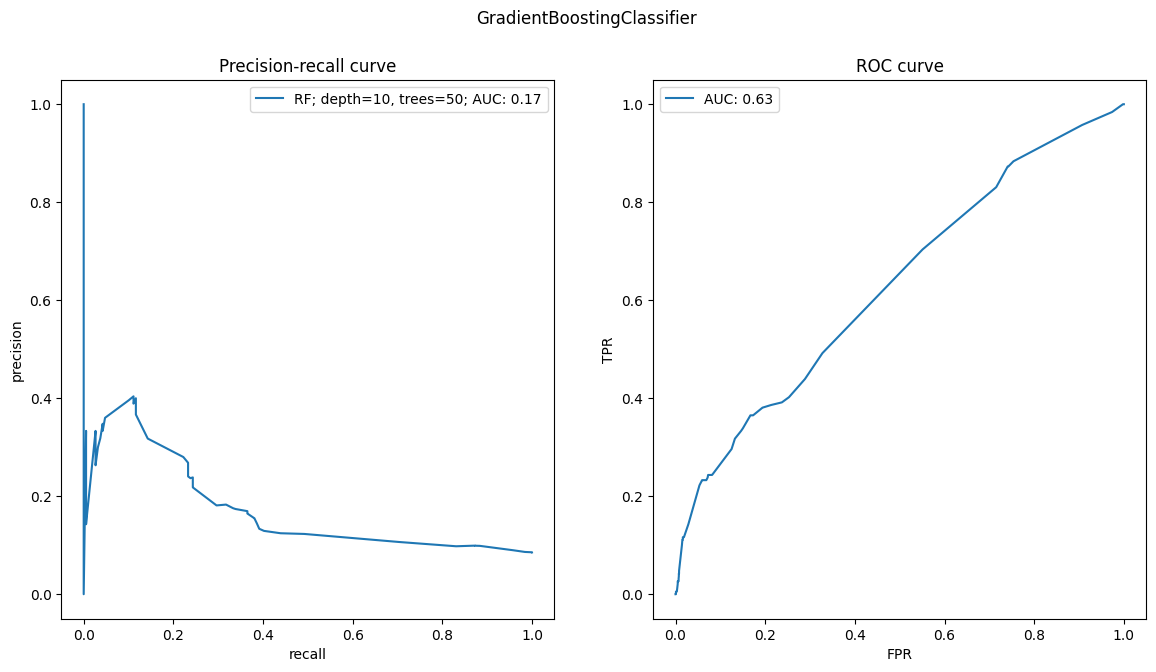

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("GradientBoostingClassifier")

gbt_model = GradientBoostingClassifier(n_estimators=10, learning_rate=0.01, max_depth=5)
gbt_model.fit(X_train[train_cols], y_train)

y_train_gbt_model_predict = gbt_model.predict_proba(X_val[train_cols])[:, 1]
plot_metrics(
            f"RF; depth=10, trees=50", 
            y_train_gbt_model_predict,
            y_val,
            figure=(fig1, ax1)
        )